In [1]:
import pandas as pd
import numpy as np
from Bio.Phylo.TreeConstruction import DistanceCalculator
from Bio import AlignIO
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
from pprint import pprint
from collections import defaultdict
from itertools import product


## If you also need to run the alignment of titered strains:
# from Bio.Alphabet import DNAAlphabet
# from Bio import SeqIO
# from Bio.Seq import Seq
# import os

In [2]:
titerfile = open('/Users/Sidney/nextstrain/fauna/data/dengue_titers.tsv', 'r')
alignmentfile = open('./smith_E_prot_aln.fasta', 'r')

In [3]:
## Read in, parse titer datafile (augur format tsv)
raw_titers = pd.read_csv(titerfile, sep='\t', header=None,
                    names=['virus', 'serum', 'serumID', 'src', 'titer'])
raw_titers = raw_titers.where((pd.notnull(raw_titers)), None) # Replace NaN with None to avoid unexpected behavior
raw_titers['serumID'].replace('DENV.*', 'agm', regex=True, inplace=True) # All the values with the strain name as serum ID are from AGMs
raw_titers['serumID'] = raw_titers['serum']+'|'+raw_titers['serumID'] # SerumStrain|patientID or SerumStrain|agm (1 monkey per strain used)
raw_titers.drop('serum', axis=1, inplace=True) # Cleanup
raw_titers.drop('src', axis=1, inplace=True)
raw_titers = raw_titers.to_dict(orient='records') #[{'serumID': 'DENV1/VIETNAM/BIDV1937/2008_agm', 'virus': 'DENV1/BOLIVIA/FSB3363/2010', 'titer': 29}, ...]

In [4]:
serum_strains = list(set([ record['serumID'] for record in raw_titers ]))
virus_strains = list(set([ record['virus'] for record in raw_titers ]))

In [15]:
### Run alignment (if needed; also import extra modules above)

# all_titered_strains = set([s.split('|')[0] for s in serum_strains] + virus_strains)
# all_sequences = { s.description.split('|')[0] : s for s in SeqIO.parse('/Users/Sidney/nextstrain/fauna/data/dengue.fasta', 'fasta')}

# titered_sequences = [ all_sequences[s] for s in all_titered_strains ]
# for s in titered_sequences:
#     s.seq = Seq(str(s.seq).replace('-', ''), alphabet=DNAAlphabet())
#     s.seq.translate()
# SeqIO.write(titered_sequences, open('titered_prot.fasta', 'w'), 'fasta')

# import os
# os.system('mafft titered_prot.fasta > titered_prot_aln.fasta')

In [5]:
## Read in protein alignment, calculate divergence values, set order of strains.

prot_aln = AlignIO.read(alignmentfile, 'fasta') # Read in protein alignment
divergence = DistanceCalculator('blosum62').get_distance(prot_aln) # Blosum62 scoring
order = [s.split('|')[0] for s in divergence.names] # Truncate to strain names
divergence = pd.DataFrame(divergence.matrix, columns=order, index=order)

In [8]:
## Make a design matrix formatted dataframe with rows and columns ordered by divergence (i.e., tree order)
serum_strains.sort(key=lambda x: order.index(x.split('|')[0]))
virus_strains.sort(key=lambda x: order.index(x))
raw_titers_matrix = pd.DataFrame(columns=serum_strains, index=virus_strains, dtype=float)
for record in raw_titers:
    raw_titers_matrix.at[record['virus'], record['serumID']] = record['titer']
log2_titers_matrix = raw_titers_matrix.applymap(np.log2) # Put everything on a log2 scale.

In [9]:
def normalize_autologous(series):
    ''' Normalize to autologous titers; return np.nan for columns missing autologous titers.'''
    strain = series.name.split('|')[0]
    if np.isnan(series[strain]):
        return series.map(lambda x: np.nan) # set the whole column to NaN if we're missing the autologous titer; drop it later.
    else:
        autologous = series[strain]
        return series.map(lambda x: autologous - x)

def normalize_max(series):
    ''' Normalize to max value in the row (i.e., the most reactive serum tested). '''
    max_titer = series.max()
    return series.map(lambda x: max_titer - x)

In [14]:
## Normalize both ways, remember to drop empty columns.
autologous_normalized_titers_matrix = log2_titers_matrix.apply(normalize_autologous, axis=0)
autologous_normalized_titers_matrix.dropna(how='all', axis=1, inplace=True) # Drop columns that didn't have an autologous titer.
max_normalized_titers_matrix = log2_titers_matrix.apply(normalize_max, axis=0)
datasets = [('divergence', divergence),
                     ('raw', raw_titers_matrix),
                     ('log2_raw', log2_titers_matrix),
                     ('log2_autologous', autologous_normalized_titers_matrix), 
                     ('log2_max', max_normalized_titers_matrix)]


In [15]:
def split_serotypes(df):
    '''Return dictionary of {virus_rows: {sera_column: df}} for plotting heatmap small multiples'''
    columns = { s : [ i for i in df.columns.values if i.startswith('DENV%d'%s) ] for s in [1,2,3,4] }
    rows = { s : [i for i in df.index.values if i.startswith('DENV%d'%s) ] for s in [1,2,3,4] }
    split_serotypes = {1: {}, 2: {}, 3: {}, 4: {}} # { serotype_1_viruses: {vs_serotype_1_sera: partial_df, vs_2: ...}, ...}
    
    for serum_serotype in [1,2,3,4]:
        for virus_serotype in [1,2,3,4]:
            partial_design_matrix = df.loc[rows[virus_serotype], columns[serum_serotype]]
            split_serotypes[serum_serotype][virus_serotype] = partial_design_matrix
    return split_serotypes

In [12]:
## Cleanup. Once we no longer need to match on names, we can shorten them before making figures.
# shortened_names = { s : s.split('/')[0]+'/'+s.split('/')[3] for s in serum_strains+virus_strains }
# for name, matrix in datasets:
#     matrix.rename(columns=shortened_names, index=shortened_names, inplace=True)

In [16]:
def calc_fst(data):
    split_data = split_serotypes(data)
    
    within_sum = 0
    within_counts = 0
    
    between_sum = 0
    between_counts = 0

    for virus in [1,2,3,4]:
        for serum in [1,2,3,4]:
            df = split_data[virus][serum]
            values = [v for v in df.values.flatten() if not np.isnan(v)]
            sum_value = sum(values)
            count_value = len(values)

            if virus == serum:
                within_sum += sum_value
                within_counts += count_value
            else:
                between_sum += sum_value
                between_counts += count_value
    within = float(within_sum) / float(within_counts)
    between = float(between_sum) / float(between_sum)
    fst = (between - within) / between
    return (within, between, fst)

fst_vals = { name: calc_fst(matrix) for name, matrix in datasets if name != 'divergence' }
pprint(fst_vals)

{'log2_autologous': (0.09791788138234629, 1.0, 0.9020821186176537),
 'log2_max': (1.9520415577034855, 1.0, -0.9520415577034855),
 'log2_raw': (5.13445274762208, 1.0, -4.13445274762208),
 'raw': (59.74914089347079, 1.0, -58.74914089347079)}


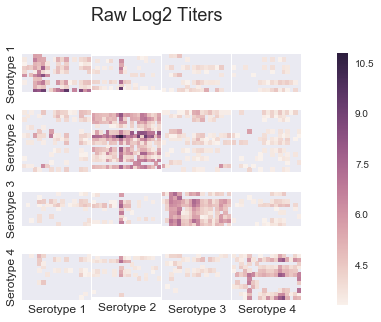

In [22]:
def plot_small_multiples(data, title):
    data = split_serotypes(data)
    fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(5,5), gridspec_kw={'wspace': 0.01, 'hspace':-0.1})
    all_values = []
    for (virus, serum) in product([1,2,3,4], repeat=2):
        all_values += [i for i in data[virus][serum].values.flatten() if not np.isnan(i) ]
    vmin_val = float(min(all_values)) # Anchor color map for entire figure at global min/max values
    vmax_val = float(max(all_values))

    cbar_axis = fig.add_axes([1.0, 0.15, .03, 0.7])

    for virus, row in enumerate(axes, start=1):
        for serum, axis in enumerate(row, start=1):
            if virus == 1 and serum == 4:
                cbar_bool = True
            else:
                cbar_bool = False
            plot = sns.heatmap(data[serum][virus], ax=axis, square=True, 
                        vmin=vmin_val, vmax=vmax_val,
                       xticklabels = False, yticklabels=False, cbar = cbar_bool, cbar_ax=cbar_axis)
            if virus == 4:
                plot.set_xlabel('Serotype %d'%serum, fontsize=12)
            if serum == 1:
                plot.set_ylabel('Serotype %d'%virus, fontsize=12)
    fig.suptitle(title, va='top', ha='center', fontsize=18)
    plt.show()

plot_small_multiples(log2_titers_matrix, 'Raw Log2 Titers')

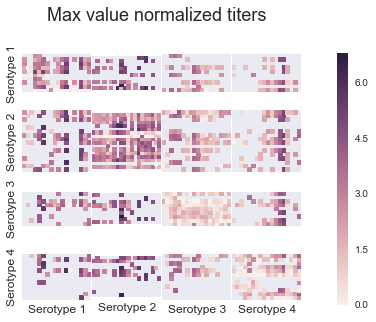

In [23]:
plot_small_multiples(max_normalized_titers_matrix, 'Max value normalized titers')

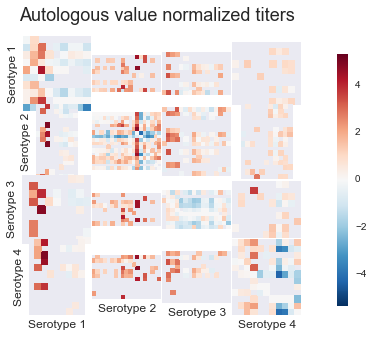

In [24]:
plot_small_multiples(autologous_normalized_titers_matrix, 'Autologous value normalized titers')

TypeError: 'numpy.float64' object is not iterable

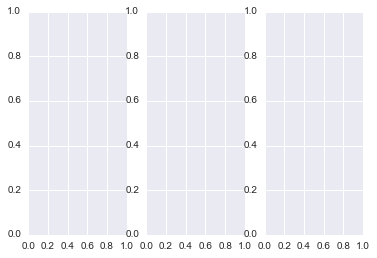

In [26]:
def get_points(xdf, ydf):
    entries = []
    for serum, series in ydf.iteritems():
        for virus, y in series:
            v_sero = virus.split('/')[0]
            s_sero = serum.split('/')[0]
            serotype = v_sero if v_sero == s_sero else 'heterologous'
            try:
                x = xdf.at[virus, serum.split('|')[0]]
            except:
                x = xdf.at[serum.split('|')[0], virus]
            if np.nan(x):
                continue
            else:
                entries.append( {'divergence': x, 'titer': y, 'serotype': serotype})
    return pd.DataFrame(entries)

log2_titers_matrix.iteritems
colors = {'DENV1': '#DF4327',
         'DENV2': '#83BA70',
         'DENV3': '#547BD3',
         'DENV4': '#781C86',
         'heterologous': 'gray'}
fig, (raw, maxnorm, autonorm) = plt.subplots(nrows=1,ncols=3)

raw_points = get_points(divergence, log2_titers_matrix)
sns.regplot(raw_points['divergence'], raw_points['titer'], color=[ colors[s] for s in raw_points['serotype']] )
